In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In [2]:
def icon_time_to_date_time(x: float) -> pd.Timestamp:
    a = int(x // 1)
    b = x % 1 * 24*60*60
    return pd.to_datetime(a, format='%Y%m%d') + pd.DateOffset(seconds=b)

In [3]:
exp_root = '/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/'
ds = xr.open_dataset(exp_root + '/my_atm_amip_R2B5_cpl_alllonlat_start01_new/my_atm_amip_R2B5_cpl_alllonlat_start01_new_atm_2d_ml_19790201T060000Z.nc')
for da_name in ds:
    print(da_name, ': ', ds[da_name].long_name)

orog :  surface altitude
ps :  surface pressure
psl :  mean sea level pressure
cosmu0 :  cosine of the zenith angle for rad. heating
rsdt :  toa incident shortwave radiation
rsut :  toa outgoing shortwave radiation
rsutcs :  toa outgoing clear-sky shortwave radiation
rlut :  toa outgoing longwave radiation
rlutcs :  toa outgoing clear-sky longwave radiation
rsds :  surface downwelling shortwave radiation
rsdscs :  surface downwelling clear-sky shortwave radiation
rlds :  surface downwelling longwave radiation
rldscs :  surface downwelling clear-sky longwave radiation
rsus :  surface upwelling shortwave radiation
rsuscs :  surface upwelling clear-sky shortwave radiation
rlus :  surface upwelling longwave radiation
ts :  surface temperature
sic :  fraction of ocean covered by sea ice
sit :  sea ice thickness
albedo :  surface albedo
clt :  total cloud cover
prlr :  large-scale precipitation flux (water)
prls :  large-scale precipitation flux (snow)
prcr :  convective precipitation flux (

In [4]:
ds_grid = xr.open_dataset(exp_root + '/my_atm_amip_R2B5_reference/icon_grid_0019_R02B05_G.nc')

In [5]:
from glob import glob

files_2d_ref = sorted(glob(exp_root + '/my_atm_amip_R2B5_reference/my_atm_amip_R2B5_reference_atm_2d_ml_*.nc'))
files_2d_alllonlat = sorted(glob(exp_root + '/my_atm_amip_R2B5_cpl_alllonlat_start01_new/my_atm_amip_R2B5_cpl_alllonlat_start01_new_atm_2d_ml_*.nc'))
files_2d_alllonlat_wpr = sorted(glob(exp_root + '/my_atm_amip_R2B5_cpl_alllonlat_with-qr-qs_start01/my_atm_amip_R2B5_cpl_alllonlat_with-qr-qs_start01_atm_2d_ml_*.nc'))
files_2d_alllon_troplat = sorted(glob(exp_root + '/my_atm_amip_R2B5_cpl_alllon_troplat_start01/my_atm_amip_R2B5_cpl_alllon_troplat_start01_atm_2d_ml_*.nc'))
files_2d_alllon_troplat_wpr = sorted(glob(exp_root + '/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01_atm_2d_ml_*.nc'))

len(files_2d_ref), len(files_2d_alllonlat), len(files_2d_alllonlat_wpr), len(files_2d_alllon_troplat), len(files_2d_alllon_troplat_wpr), 
# (728, 205, 185, 851, 724)

(728, 205, 185, 724, 724)

In [6]:
def sort_out_timestamps(files, timestamps):
    pop_idx = []
    for i,file in enumerate(files):
        if any([time in file for time in timestamps]):
            pop_idx.append(i)
    if len(pop_idx) > 0:
        print(f'Sorting out {len(pop_idx)} files')
    for idx in pop_idx[::-1]: # Pop list starting from last idx
        files.pop(idx)

# Only keep six hourly steps
sort_out_times = ['T010000Z','T020000Z','T030000Z','T040000Z','T050000Z',
                  'T070000Z','T080000Z','T090000Z','T100000Z','T110000Z',
                  'T130000Z','T140000Z','T150000Z','T160000Z','T170000Z',
                  'T190000Z','T200000Z','T210000Z','T220000Z','T230000Z']

sort_out_timestamps(files_2d_ref, sort_out_times)
sort_out_timestamps(files_2d_alllonlat, sort_out_times)
sort_out_timestamps(files_2d_alllonlat_wpr, sort_out_times)
sort_out_timestamps(files_2d_alllon_troplat, sort_out_times)
sort_out_timestamps(files_2d_alllon_troplat_wpr, sort_out_times)

len(files_2d_ref), len(files_2d_alllonlat), len(files_2d_alllonlat_wpr), len(files_2d_alllon_troplat), len(files_2d_alllon_troplat_wpr), 

Sorting out 15 files


(728, 205, 170, 724, 724)

In [7]:
sim_names = [
    'reference',
    'alllonlat',
    'alllonlat_wpr',
    'alllon_troplat',
    'alllon_troplat_wpr',
]

In [8]:
file_lists = [
    files_2d_ref,
    files_2d_alllonlat,
    files_2d_alllonlat_wpr,
    files_2d_alllon_troplat,
    files_2d_alllon_troplat_wpr,
]

In [9]:
def rad2degr(x):
    return x*180/np.pi

def plot_icon_tricolor(ax, clon_bnds, clat_bnds, vals, **kwargs):
    a = rad2degr(clon_bnds.flatten()[:])
    b = rad2degr(clat_bnds.flatten()[:])
    c = np.arange(clon_bnds.size).reshape(clon_bnds.shape)
    plot = ax.tripcolor(a,
                        b,
                        c,
                        vals,
                        **kwargs)
    
    return plot

In [10]:
def fix_periodicity_for_triplot(clon_bnds):
    '''
    Takes in clon bnds coordinate list and adds/subtracts 2pi
    to/from all points where one edge is with other sign
    '''
    mask = np.any(np.abs(np.diff(clon_bnds, axis=1)) > 4, axis=1)
    vert_sign_sum = np.sum(np.sign(clon_bnds), axis=1)
    pmask = np.sign(vert_sign_sum)[:,None] > np.sign(clon_bnds)
    pmask = pmask & mask[:,None]
    nmask = np.sign(vert_sign_sum)[:,None] < np.sign(clon_bnds)
    nmask = nmask & mask[:,None]

    clon_bnds[pmask] += 2*np.pi
    clon_bnds[nmask] -= 2*np.pi
    return clon_bnds

# Precip analysis

In [11]:
clat_tropics_mask = (ds_grid.clat.values < 23.43615*np.pi/180) & (ds_grid.clat.values > -23.43615*np.pi/180)
clat_tropics_mask.sum() / clat_tropics_mask.size

0.396728515625

In [12]:
used_mask = clat_tropics_mask#np.s_[:]
used_timesteps = 4*14

In [14]:
from tqdm.auto import tqdm

prec_ref = []
for f in tqdm(files_2d_ref[:used_timesteps]):
    ds = xr.open_dataset(f)
    prec_ref.append(ds.pr.values[...,used_mask].squeeze())

prec_ref = np.array(prec_ref)

  0%|          | 0/56 [00:00<?, ?it/s]

In [98]:
prec_ml = []
for f in tqdm(files_2d_alllon_troplat[:used_timesteps]):
# for f in tqdm(files_2d_alllonlat[:used_timesteps]):
    ds = xr.open_dataset(f)
    prec = ds.prcr.values[...,used_mask].squeeze() # Take only convective precip as it predicts mixed lr and convective precip due to training data

    prec_ml.append(prec)

prec_ml = np.array(prec_ml)

  0%|          | 0/56 [00:00<?, ?it/s]

In [16]:
prec_ml_wpr = []
for f in tqdm(files_2d_alllon_troplat_wpr[:used_timesteps]):
# for f in tqdm(files_2d_alllonlat_wpr[:used_timesteps]):
    ds = xr.open_dataset(f)
    prec = ds.prcr.values[...,used_mask].squeeze() # Take only convective precip as it predicts mixed lr and convective precip due to training data

    prec_ml_wpr.append(prec)

prec_ml_wpr = np.array(prec_ml_wpr)

  0%|          | 0/56 [00:00<?, ?it/s]

In [17]:
prec_ref.shape, prec_ml.shape, prec_ml_wpr.shape

((56, 32500), (56, 32500), (56, 32500))

In [18]:
file = np.load('../../local_data/20240301-narval_prec_kgm-2s-1.npz')
prec_narval = file['prec']

prec_narval_max = np.nanmax(prec_narval)

In [19]:
prec_ml[prec_ml > prec_narval_max], prec_ml_wpr[prec_ml_wpr > prec_narval_max]

(array([], dtype=float32), array([], dtype=float32))

In [20]:
prec_ml[prec_ml < 0] = 0
prec_ml_wpr[prec_ml_wpr < 0] = 0

In [21]:
def prec_unit_conv(prec):
    rho_water = 998 # kg m-3 (20°C)
    # Converts prec in kg s-1 m-2 to mm hour-1
    return prec/rho_water * 1000*3600# * 24

prec_narval = prec_unit_conv(prec_narval)
prec_ml = prec_unit_conv(prec_ml)
prec_ml_wpr = prec_unit_conv(prec_ml_wpr)
prec_ref = prec_unit_conv(prec_ref)

prec_narval_max = np.nanmax(prec_narval)

In [22]:
q = 0.9999

narv_q = np.quantile(prec_narval.ravel(), q)
ml_q = np.quantile(prec_ml.ravel(), q)
ml_wpr_q = np.quantile(prec_ml_wpr.ravel(), q)
ref_q = np.quantile(prec_ref.ravel(), q)

print(f'{q}\'th quantile of NARVAL: ', narv_q)
print(f'{q}\'th quantile of config 3: ', ml_q)
print(f'{q}\'th quantile of config 4: ', ml_wpr_q)
print(f'{q}\'th quantile of reference: ', ref_q)

0.9999'th quantile of NARVAL:  18.440128326414982
0.9999'th quantile of config 3:  13.598885819151597
0.9999'th quantile of config 4:  1.3378404408459417
0.9999'th quantile of reference:  6.499046990061225


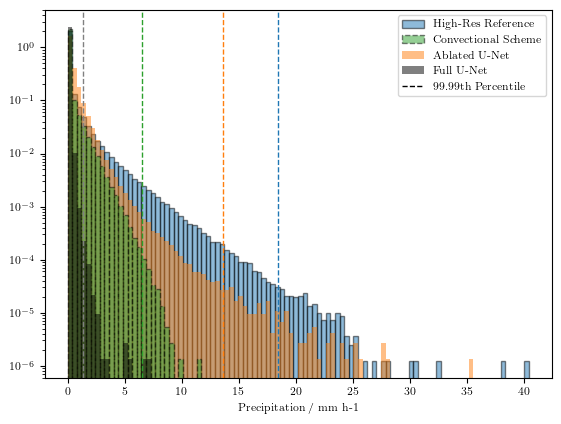

In [23]:
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size 
setup_mpl_tex()

alpha=0.5
fig, ax = plt.subplots(constrained_layout=True, figsize=set_size('textwidth'))

cmap = plt.get_cmap('tab10')

ax.hist(prec_narval.ravel(), bins=100, range=(0,prec_narval_max), density=True, alpha=alpha, color=cmap(0), label='High-Res Reference', edgecolor='black', linestyle='-')
ax.hist(prec_ml.ravel(), bins=100, range=(0,prec_narval_max), density=True, alpha=alpha, color=cmap(0.1), label='Ablated U-Net')
ax.hist(prec_ref.ravel(), bins=100, range=(0,prec_narval_max), density=True, alpha=alpha, color=cmap(0.2), label='Convectional Scheme', edgecolor='black', linestyle='--')
ax.hist(prec_ml_wpr.ravel(), bins=100, range=(0,prec_narval_max), density=True, color='black', alpha=alpha, label='Full U-Net')

ax.axvline(narv_q, ls='--', lw=1, color=cmap(0))
ax.axvline(ml_q, ls='--', lw=1, color=cmap(0.1))
ax.axvline(ref_q, ls='--', lw=1, color=cmap(0.2))
ax.axvline(ml_wpr_q, ls='--', lw=1, color='grey')
ax.plot([], [], ls='--', lw=1, color='black', label='99.99th Percentile')

ax.set_xlabel('Precipitation / mm h-1')
ax.set_yscale('log')

# Create legend with switched labels in legend (due to plotting order due to alpha values)
handles, labels = ax.get_legend_handles_labels()
handles[1], handles[2] = handles[2], handles[1]
labels[1], labels[2] = labels[2], labels[1]
ax.legend(handles, labels)
# ax.legend()

# fig.savefig('../../Figures/Pdfplots/PrecipOnlineComparisonTroplat2Weeks_tropicsonly.pdf', dpi=100)
# fig.savefig('../../Figures/Pdfplots/PrecipOnlineComparisonAlllat2Weeks_tropicsonly.pdf', dpi=100)
plt.show()

# Spatial analysis

In [46]:
ds_grid = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_start01/icon_grid_0019_R02B05_G.nc')

ds_narv_13 = xr.open_dataset('/scratch/b/b309215/ProcessedData/work/bd1179/b309215/heuer23_convection_parameterization/ProcessedData/dei4_NARVALI_201312_R02B05_m2degr_pr_monmean.nc')
ds_narv_16 = xr.open_dataset('/scratch/b/b309215/ProcessedData/work/bd1179/b309215/heuer23_convection_parameterization/ProcessedData/dei4_NARVALI_201608_R02B05_m2degr_pr_monmean.nc')
ds_ablated = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_start01/MyStuff/my_atm_amip_R2B5_cpl_alllon_troplat_start01_atm_2d_ml_19790_prcr_monmean.nc')
ds_full    = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01/MyStuff/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01_atm_2d_ml_19790_prcr_monmean.nc')
ds_conventional = xr.open_dataset('/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_reference/MyStuff/my_atm_amip_R2B5_reference_atm_2d_ml_19790_pr_monmean.nc')
ds_conventional = ds_conventional.isel(time=slice(1,None))

In [26]:
narval_mask = ~np.isnan(ds_narv_13.pr.values[0])
narval_mask.sum()

4596

In [27]:
file_roots = [
    '/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_reference/my_atm_amip_R2B5_reference_atm_2d_ml_1979',
    '/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_start01/my_atm_amip_R2B5_cpl_alllon_troplat_start01_atm_2d_ml_1979',
    '/work/bd1179/b309215/icon-a-ml/build_intel_no_openmp/experiments_project/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01/my_atm_amip_R2B5_cpl_alllon_troplat_with-qr-qs_start01_atm_2d_ml_1979'
]
mean_months = ['02', '03', '04', '05']

prec_vals_monthly = []
for file_root in tqdm(file_roots):
    for month in tqdm(mean_months, leave=False):
        if 'R2B5_ref' in file_root:
            pr_var = 'pr'
        else:
            pr_var = 'prcr'
        print(pr_var)
        files = glob(file_root+month+'*')
        prec_vals = np.array([xr.open_dataset(file)[pr_var].values.squeeze()[narval_mask] for file in files])
        prec_vals_monthly.append(np.mean(prec_vals, axis=0))

prec_vals_monthly_stacked = np.stack(prec_vals_monthly).reshape(3,4,-1)
prec_vals_monthly_stacked.shape

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

pr
pr
pr
pr


  0%|          | 0/4 [00:00<?, ?it/s]

prcr
prcr
prcr
prcr


  0%|          | 0/4 [00:00<?, ?it/s]

prcr
prcr
prcr
prcr


In [33]:
def rad2degr(x):
    return x*180/np.pi

def plot_icon_tricolor(ax, clon_bnds, clat_bnds, vals, **kwargs):
    a = rad2degr(clon_bnds.flatten()[:])
    b = rad2degr(clat_bnds.flatten()[:])
    c = np.arange(clon_bnds.size).reshape(clon_bnds.shape)
    
    plot = ax.tripcolor(a,
                        b,
                        c,
                        vals,
                        **kwargs)
    
    return plot

In [34]:
clon = ds_grid.clon.values
clat = ds_grid.clat.values
clon_bnds = ds_grid.clon_vertices.values
clat_bnds = ds_grid.clat_vertices.values

In [35]:
def fix_periodicity_for_triplot(clon_bnds):
    '''
    Takes in clon bnds coordinate list and adds/subtracts 2pi
    to/from all points where one edge is with other sign
    '''
    mask = np.any(np.abs(np.diff(clon_bnds, axis=1)) > 4, axis=1)
    vert_sign_sum = np.sum(np.sign(clon_bnds), axis=1)
    pmask = np.sign(vert_sign_sum)[:,None] > np.sign(clon_bnds)
    pmask = pmask & mask[:,None]
    nmask = np.sign(vert_sign_sum)[:,None] < np.sign(clon_bnds)
    nmask = nmask & mask[:,None]

    clon_bnds[pmask] += 2*np.pi
    clon_bnds[nmask] -= 2*np.pi
    return clon_bnds

clon_bnds = fix_periodicity_for_triplot(clon_bnds)

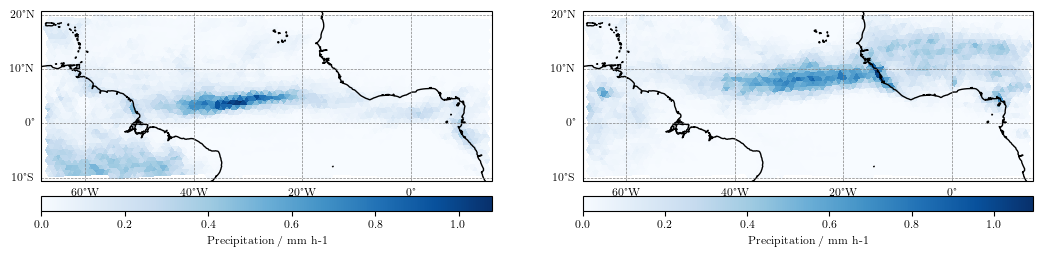

In [36]:
# from convection_param.HelperFuncs import plot_icon_tricolor
from matplotlib.colors import TwoSlopeNorm, LogNorm#, Normalize
import matplotlib.ticker as mticker

current_cmap = plt.get_cmap(name='Blues').copy()
current_cmap.set_bad(color='#bcb5bb')

fig, axes = plt.subplots(1,2,subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(2*6.4,2*4.8))#, figsize=[2*e for e in cpm_tex.set_size('textwidth')])


for ax,ds in zip(axes, [ds_narv_13, ds_narv_16]):
    mapplot = plot_icon_tricolor(ax,
                                 # ds_plot['clon_bnds'].values,
                                 # ds_plot['clat_bnds'].values,
                                 # ds_plot['pfull'].values[0,-1,:].squeeze(),
                                 clon_bnds[narval_mask],
                                 clat_bnds[narval_mask],
                                 prec_unit_conv(ds.pr.values[0,narval_mask])/3600,
                                 # norm=LogNorm(),#TwoSlopeNorm(0),
                                 cmap=current_cmap)

    ax.coastlines()
    # ax.set_xlim(-np.pi, np.pi)
    # ax.set_ylim(-np.pi/2, np.pi/2)

    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20])
    # gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
    # gl.ylocator = LatitudeLocator()
    # gl.xformatter = LongitudeFormatter()
    # gl.yformatter = LatitudeFormatter()

    ax.set_extent([-68, 15, -8, 16])
    fig.colorbar(mapplot, label='Precipitation / mm h-1', orientation='horizontal', aspect=30, pad=0.02)#, label='Average Number of Convective Columns')

    ax.set_rasterization_zorder(0)
    # ax.set_title('Precipitation')

plt.show()

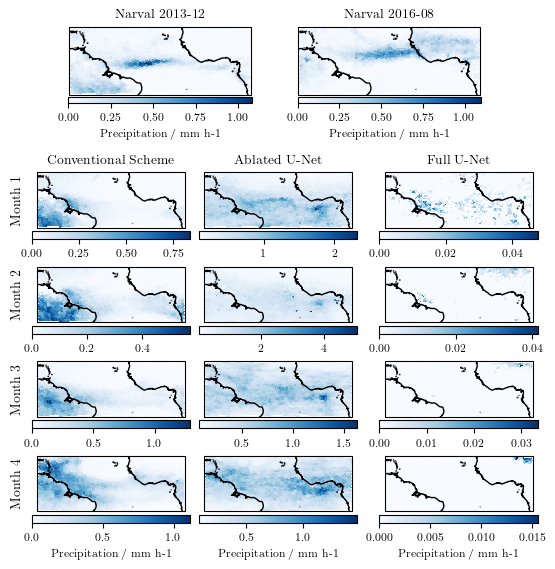

In [96]:
from convection_param.setup_mpl_tex import setup_mpl_tex, set_size 

setup_mpl_tex()

figsize = list(set_size('textwidth'))
# figsize[1] += 1.5

n_rows = 4
n_cols = 3
fig, axes = plt.subplots(n_rows,n_cols,subplot_kw=dict(projection=ccrs.PlateCarree()),constrained_layout=True,
                         figsize=figsize)

titles = ['Conventional Scheme', 'Ablated U-Net', 'Full U-Net']
for i in range(n_rows):
    for j,ds in zip(range(n_cols), [ds_conventional, ds_ablated, ds_full]):
        ax = axes[i,j]
        ax.set_rasterization_zorder(0)
        if i == 0:
            ax.set_title(titles[j])
        if j == 0: # if j==0, conventional scheme, so take all precipitation (convective + large-scale)
            pr_var = 'pr'
        else: # else, ml-scheme, so take only convective precip (includes large-scale)
            pr_var = 'prcr'
        
        if j == 0:
            ax.text(x=-0.1, y=0.5, s=f'Month {i+1}', rotation='vertical', ha='right', va='center', fontsize=10, transform=ax.transAxes, zorder=1)
        # vals = prec_unit_conv(prec_vals_monthly_stacked[j,i,:])
        vals = prec_unit_conv(ds[pr_var].values[i,narval_mask])
        vals[vals<0] = 0
        mapplot = plot_icon_tricolor(ax,
                                     # ds_plot['clon_bnds'].values,
                                     # ds_plot['clat_bnds'].values,
                                     # ds_plot['pfull'].values[0,-1,:].squeeze(),
                                     clon_bnds[narval_mask],
                                     clat_bnds[narval_mask],
                                     vals,
                                     zorder=-1,
                                     # vmin = 0, vmax=2,
                                     # norm=LogNorm(),#TwoSlopeNorm(0),
                                     cmap=current_cmap)
        # print(np.max(prec_unit_conv(ds[pr_var].values[i,narval_mask])))

        ax.coastlines()
        ax.set_extent([-68, 15, -8, 16])
        # gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
        # gl.top_labels = False
        # gl.right_labels = False
        # gl.ylocator = mticker.FixedLocator([-10, 0, 10, 20])
        # ax.set_extent([-68, 15, -8, 16])
        if i == n_rows-1:
            fig.colorbar(mapplot, label='Precipitation / mm h-1', orientation='horizontal', ax=ax)#, aspect=30, pad=0.02, ax=ax)#, label='Average Number of Convective Columns')
        else:
            fig.colorbar(mapplot, orientation='horizontal', ax=ax)#, aspect=30, pad=0.02, ax=ax)#, label='Average Number of Convective Columns')
        # fig.colorbar(mapplot, label='Precipitation / mm h-1', orientation='horizontal', aspect=30, pad=0.02, ax=ax)#, label='Average Number of Convective Columns')

axnarv1 = fig.add_axes([3/24, 1.1, 1/3, 1/5], label='axnarv1', projection=ccrs.PlateCarree())
axnarv2 = fig.add_axes([13/24, 1.1, 1/3, 1/5], label='axnarv2', projection=ccrs.PlateCarree())

for ax,ds in zip([axnarv1, axnarv2], [ds_narv_13, ds_narv_16]):
    ax.set_rasterization_zorder(0)
    mapplot = plot_icon_tricolor(ax,
                                 # ds_plot['clon_bnds'].values,
                                 # ds_plot['clat_bnds'].values,
                                 # ds_plot['pfull'].values[0,-1,:].squeeze(),
                                 clon_bnds[narval_mask],
                                 clat_bnds[narval_mask],
                                 prec_unit_conv(ds.pr.values[0,narval_mask])/3600,
                                 # norm=LogNorm(),#TwoSlopeNorm(0),
                                 zorder=-1,
                                 cmap=current_cmap)

    ax.coastlines()
    ax.set_extent([-68, 15, -8, 16])
    fig.colorbar(mapplot, label='Precipitation / mm h-1', orientation='horizontal', aspect=30, pad=0.02)#, label='Average Number of Convective Columns')

axnarv1.set_title('Narval 2013-12')
axnarv2.set_title('Narval 2016-08')

# fig.savefig('../../Figures/Pdfplots/PrecipSpatialMean4Month.pdf', bbox_inches='tight', dpi=200)

plt.show()